# Processing the EDGAR Data Set

Given a year, get data for the first day of the month for every month in the year. Example URL: http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2003/Qtr1/log20030101.zip

### Generate URLs

In [1]:
year = 2005 # environmental variable

In [2]:
url_base = 'http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/'

In [3]:
url_mid = '/log' + str(year)

In [4]:
url_final = '01.zip'

In [5]:
urls = []
# use range to get all 12 months
for x in range(1,13):
    if (x < 4):
        urls.append(url_base + str(year) + '/Qtr1' + url_mid + '0' + str(x) + url_final)
    elif (x >=4 and x < 7):
        urls.append(url_base + str(year) + '/Qtr2' + url_mid + '0' + str(x) + url_final)
    elif (x >= 7 and x < 10):
        urls.append(url_base + str(year) + '/Qtr3' + url_mid + '0' + str(x) + url_final)
    else:
        urls.append(url_base + str(year) + '/Qtr4' + url_mid + str(x) + url_final)
        
print(urls)

['http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2005/Qtr1/log20050101.zip', 'http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2005/Qtr1/log20050201.zip', 'http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2005/Qtr1/log20050301.zip', 'http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2005/Qtr2/log20050401.zip', 'http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2005/Qtr2/log20050501.zip', 'http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2005/Qtr2/log20050601.zip', 'http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2005/Qtr3/log20050701.zip', 'http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2005/Qtr3/log20050801.zip', 'http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2005/Qtr3/log20050901.zip', 'http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2005/Qtr4/log20051001.zip', 'http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2005/Qtr4/log20051101.zip', 'http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2005/Qt

The log files are large, so we will read them from the zip files instead of extracting them

In [6]:
import zipfile
import requests
from io import StringIO,BytesIO
import pandas as pd
from pandas import *
import re
import numpy
import scipy
from scipy import stats
import datetime
import matplotlib.pyplot as plt

In [7]:
column_names = ['ip','date','time','zone','cik','accession','doc/extention','code','filesize','idx','norefer','noagent','find','crawler','browser']
full_logs = pd.DataFrame(columns=column_names)

Default Values:
* ip: unknown
* date: derive from file date
* time: unknown
* zone: 0
* cik: unknown
* accession: unknown
* doc: unknown
* code: unknown
* size: mean
* idx: 0
* noreferer: 0
* noagent: 0
* find: 0
* crawler: 0
* browser: unknown

Numeric defaults are based on the README that comes with each log

In [8]:
dataframe_collection = []
for url in urls:
    #print url
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(BytesIO(r.content))
    st = pd.read_csv(z.open(url[-15:-3]+'csv'))
    
    # Handle Missing Data
    
    # Replace missing numeric values and categorical that have default 0
    st.fillna({'zone': 0, 'idx': 0,'noreferer': 0,'noagent': 0,'find': 0,'crawler': 0}, inplace=True)
    # Replace missing categorical values
    st.fillna({'ip':'unknown', 'time':'unknown','cik':'unknown','accession':'unknown','code':'unknown','browser':'unknown'}, inplace=True)
    st.fillna({'doc':'unknown', 'extention':'unknown'}, inplace=True)
    # Replace missing dates from file name
    date_formatted = url[-12:-8]+'-'+url[-8:-6] + '-' + url[-6:-4]
    st.fillna({'date': date_formatted}, inplace=True)
    # Replace missing file sizes with mean
    st.fillna({'size': scipy.mean(st['size'])}, inplace=True)
    dataframe_collection.append(st)

### Highest accession Number by month

In [9]:
def accessionNumber(df):
    allAccessionNumbers=[]
    Frequencies=[]
    modecount=df['accession'].value_counts()
    Frequencies.append(modecount[0])
    mode=df['accession'].value_counts().index.tolist()
    allAccessionNumbers.append(mode[0])
    dfAccessionNumber=pd.DataFrame({'Accession Number':allAccessionNumbers, 'Frequency':Frequencies})
    c=list(dfAccessionNumber.groupby('Accession Number')['Frequency'].sum())
    a=dfAccessionNumber.groupby('Accession Number')['Frequency'].sum().index.tolist()
    df1=pd.DataFrame({'Accession Number':a, 'Frequency':c})
    b=list(df1.loc[df1['Frequency']==df1.max()['Frequency']]['Accession Number'])
    mostFrequentAccessionNumber=pd.DataFrame({'Accession Number':[b[0]]})
    return mostFrequentAccessionNumber

In [10]:
accessionNumberPerMonth=[]
for i in range(0,len(dataframe_collection)):
    accessionNumberPerMonth.append(accessionNumber(dataframe_collection[i]))
months=['Jan','Feb','March','April','May','June','July','Aug','Sept','Oct','Nov','Dec']
accessionNumberPerMonth=pd.DataFrame({'Month': months,'Accession Number':accessionNumberPerMonth})
    

### Browser frequencies by month

In [11]:
def browserFrequency(df):
    modecount=df['browser'].value_counts()
    mode=modecount.index.tolist()
    dfBrowser=pd.DataFrame({'Browser':mode , 'Frequencies': modecount.values})
    return dfBrowser

In [12]:
browserFrequencyByMonth=[]
for i in range(0,len(dataframe_collection)):
    browserf=browserFrequency(dataframe_collection[i])
    browserFrequencyByMonth.append(browserf)

### Most Frequent times accessed

In [13]:
timeFrequencyCollection=[]
for x in range(0,len(dataframe_collection)):
    dftest=pd.DataFrame(dataframe_collection[x])
    dftest['time']=pd.to_datetime(dftest['time'])
    dftest.set_index(dftest['time'],inplace=True)
    dftest=dftest.groupby(TimeGrouper(freq='H'))
    d=dftest['time'].count()
    timeFrequencyCollection.append(d)
    timeFrequencyCollection[x]=pd.DataFrame(timeFrequencyCollection[x])

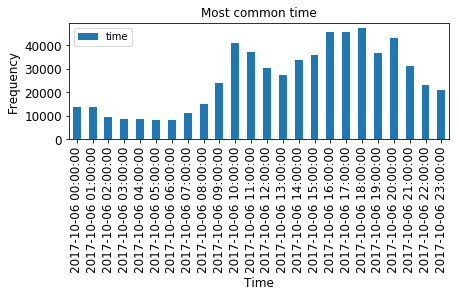

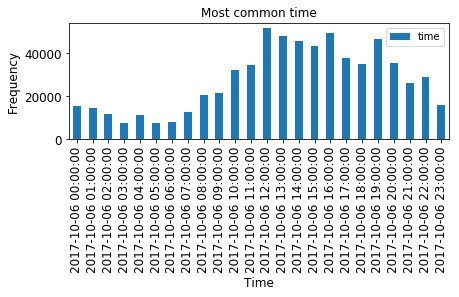

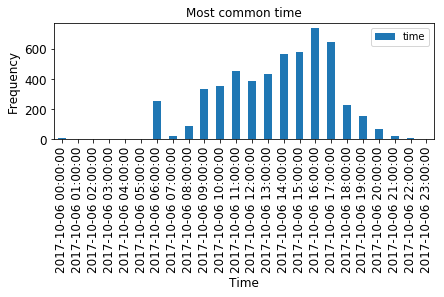

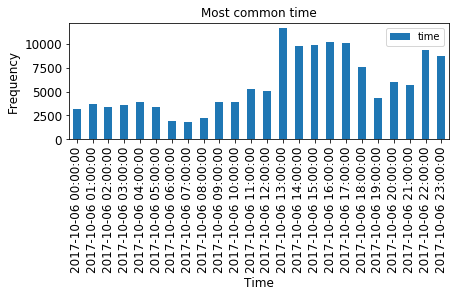

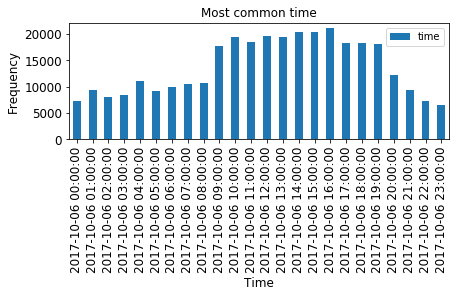

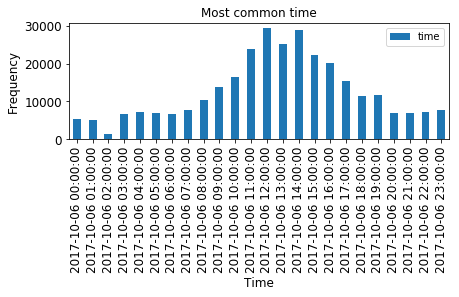

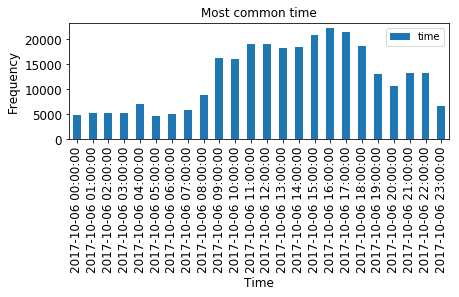

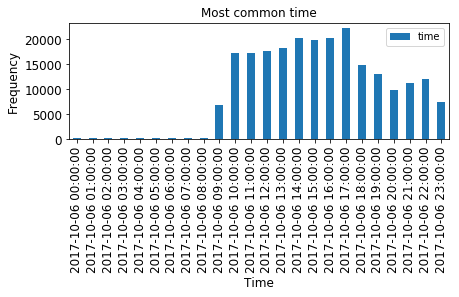

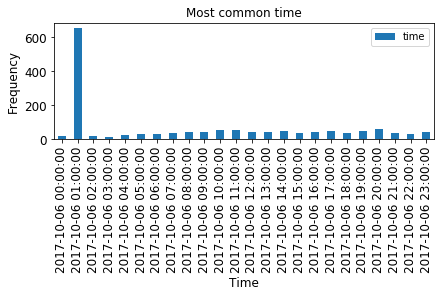

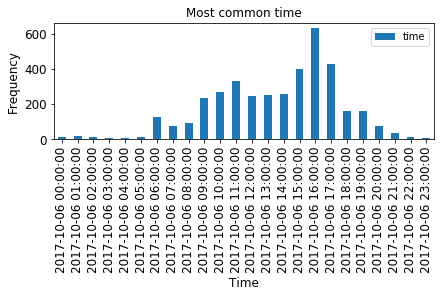

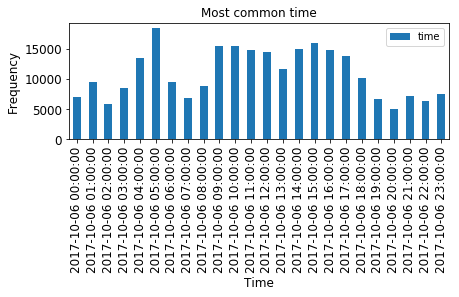

In [14]:
figTime, axTime = plt.subplots(nrows=6, ncols=2)
for i in range(1,len(timeFrequencyCollection)):
    plt.close('all')
    plt.subplot(6,2,i+1)
    axTime = timeFrequencyCollection[i]['time'].plot(kind='bar', title ="Most common time",figsize=(15, 15), legend=True, fontsize=12)
    axTime.set_xlabel("Time", fontsize=12)
    axTime.set_ylabel("Frequency", fontsize=12)
    figTime = axTime.get_figure()
    #fig.savefig("GenderRatio")
    plt.show()

### Top 5 CIK accessed in each file

In [15]:
topFrequencyOfCIK=[]
for x in range(0,len(dataframe_collection)):
    c=list(dataframe_collection[x]['cik'].astype(int).astype(str))
    data=pd.DataFrame({'Cik':c})
    frequencyOfCik=data['Cik'].value_counts()
    freq=pd.DataFrame({'Frequency':frequencyOfCik})
    topFrequencyOfCIK.append(freq[:5])

### Outliers- Anomalies Observed in Size column

In [16]:
dfdes=dataframe_collection[0].describe()

In [17]:
dfsize=[]
for x in range(0,len(dataframe_collection)):
    dfsize.append(dataframe_collection[x]['size'])
    dfsize[x]=pd.DataFrame(dfsize[x])

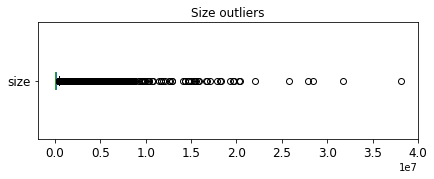

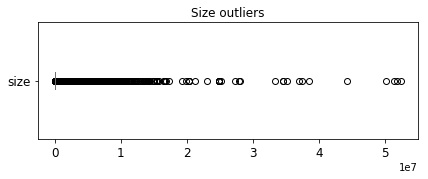

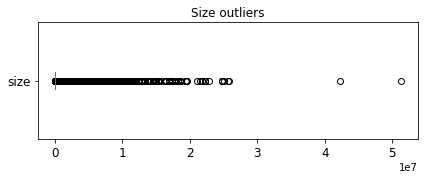

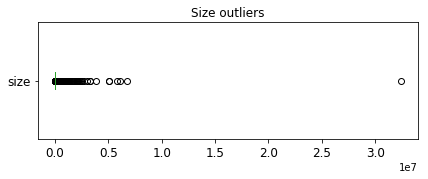

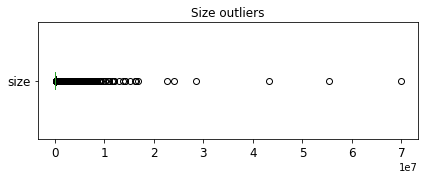

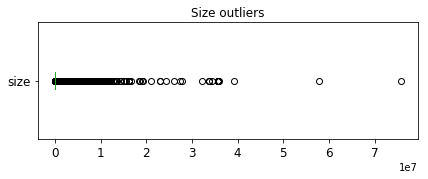

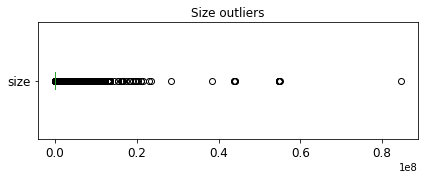

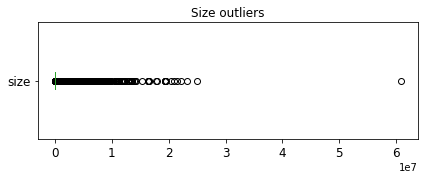

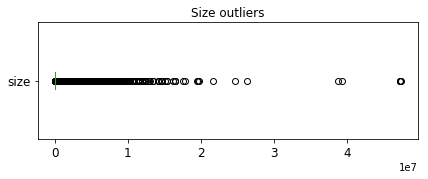

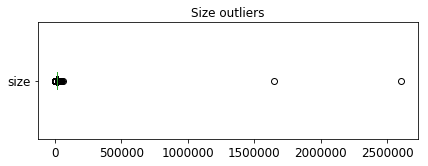

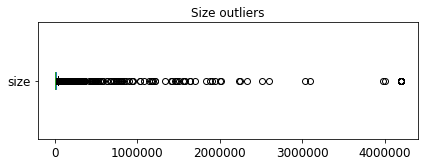

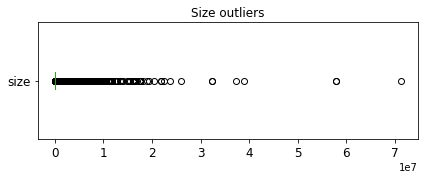

In [18]:
figSize, axSize = plt.subplots(nrows=6, ncols=2)
for i in range(0,len(dfsize)):
    plt.close('all')
    plt.subplot(6,2,i+1)
    axSize=dfsize[i]['size'].plot(kind='box',title ="Size outliers",figsize=(15, 15), legend=True,fontsize=12,vert=False)
    figSize = axSize.get_figure()
    plt.show()

In [20]:

dfdes.to_excel(writer,sheet_name='Describe')

workbook=writer.book
worksheet=writer.sheets['Describe']


In [23]:
writer=pd.ExcelWriter('chart1.xlsx',engine='xlsxwriter')
dfdes=[]

for x in range(0,len(dataframe_collection)):
    dfdes.append(dataframe_collection[x].describe())

for j in range(0,len(dfdes)):
    dfdes[j].to_excel(writer,sheet_name='Describe',startrow=(j*11))
    
accessionNumberPerMonth.to_excel(writer, sheet_name='Highest Accessed files by Month')
for x in range(0,len(browserFrequencyByMonth)):
    browserFrequencyByMonth[x].to_excel(writer,sheet_name='Browser Frequency By Month',startrow=0+x*14)
for i in range(0,len(topFrequencyOfCIK)):
    topFrequencyOfCIK[i].to_excel(writer,sheet_name='Top 5 CIK',startrow=0+i*7)